### Using Decision Tree for Loan Default Prediction

### What is our objective ?
* To reliably predict wether a person's loan payment will be defaulted based on features such as Salary, Account Balance etc.

### Getting to know the dataset!
LoanDefault dataset contains historic data for loan defaultees, along with their associated financial background, it has the following features.
* Employed - Employment status of the borrower, (1 - Employed | 0 - Unemployed).
* Bank Balance - Account Balance of the borrower at the time of repayment / default.
* Annual Salary - Per year income of the borrower at the time of repayment / default.
* Default - Target variable, indicated if the borrower repayed the loaned amount within the stipulated time period, (1 - Defaulted | 0 - Re-Paid).

### Approach
* This is an trivial example for dataset containing class imbalance, considering most of the people will be repaying their loan without default.
* So, we have to explore our data to check for imbalance, handle it using various techniques.
* Explore the correlation between various features in the dataset
* Split the preprocessed dataset into train and test sets respectively.
* Train a DecisionTree (Classifier) using mlpack.
* Finally we'll predict on the test set and using various evaluation metrics such as Accuracy, F1-Score, ROC AUC to judge the performance of our model on unseen data.

#### NOTE: In this example we'll be implementing 4 parts i.e modelling on imbalanced, oversampled, SMOTE & undersampled data respectively.

In [2]:
# Import necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlpack
from sklearn.metrics import *

In [3]:
%matplotlib inline
sns.set(color_codes=True)

### Load the data

In [4]:
# Load loan default prediction (LoanDefault) dataset.
loanData = pd.read_csv("http://datasets.mlpack.org/LoanDefault.csv")

### Explore the data

In [5]:
# Examine first 5 samples from the dataset.
loanData.head()

,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,8754.36,532339.56,0
1,0,9806.16,145273.56,0
2,1,12882.60,381205.68,0
3,1,6351.00,428453.88,0
4,1,9427.92,461562.00,0


In [6]:
# Examine the shape of the dataframe.
print(f"# of rows: {loanData.shape[0]}")
print(f"# of cols: {loanData.shape[1]}")

# of rows: 10000
# of cols: 4


In [7]:
# Concise summary if all the features in the dataframe.
loanData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Employed       10000 non-null  int64  
 1   Bank Balance   10000 non-null  float64
 2   Annual Salary  10000 non-null  float64
 3   Defaulted?     10000 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 312.6 KB


From the above summary statistic we can infer there is no missing or categorical variables to handle in our dataset.

In [7]:
## Check the percentage of missing values.
(loanData.isnull().sum() / len(loanData)) * 100

Employed         0.0
Bank Balance     0.0
Annual Salary    0.0
Defaulted?       0.0
dtype: float64

### Part 1 - Modelling using Imbalanced dataset.

### Visualize data distribution

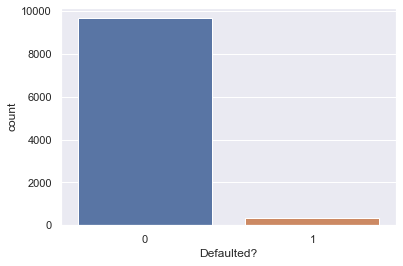

In [8]:
# Visualize the distibution of target classes.
sns.countplot(x="Defaulted?", data=loanData)
plt.show()

From the above visualization, we can observe that the presence of "0" and "1", so there is a huge class imbalance. For the first part we would not be handling the class imbalance. In order to see how our model performs on the raw imbalanced data

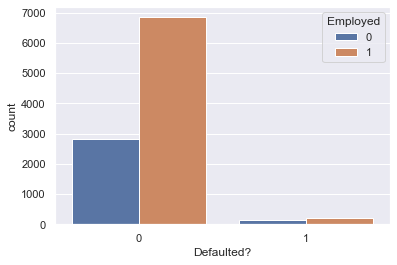

In [9]:
# Visualize the distibution of target classes with respect to Employment.
sns.countplot(x="Defaulted?", hue="Employed", data=loanData)
plt.show()

### Visualize Correlation

In [13]:
def PlotHeatMap(data, figWidth=8, figHeight=8):
    """
    Generates an heatmap to visualize the correlation between various features in the dataset.
    
        Parameter:
            data (DataFrame): Pandas dataframe to be ploted.
            figWidth (int): Width of the figure.
            figHeight (int): Height of the figure.
            
        Returns:
            None
    """
    plt.figure(figsize=(figWidth,figHeight))
    sns.heatmap(data.corr(), square=True, 
                annot=True, fmt=".2f")
    plt.show()

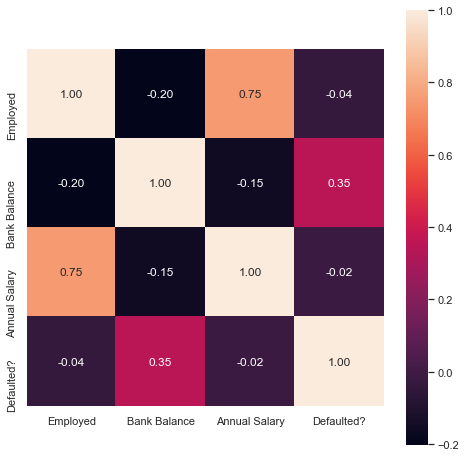

In [11]:
# Plot the correlation matrix as heatmap.
PlotHeatMap(loanData)

In [17]:
def FeatureTargetSplit(data):
    """
    Returns the Features of interest and targets.
        
        Parameter:
            data (DataFrame): Pandas dataframe which is to be splited into features and targets.
        
        Returns:
            features (DataFrame): Pandas dataframe consisting of the features.
            target (DataFrame): Pandas dataframe containing the target.
    """
    featureNames = ["Employed", "Bank Balance", "Annual Salary"]
    features=data[featureNames]
    target=data["Defaulted?"]
    return features, target

In [13]:
features, target = FeatureTargetSplit(loanData)

### Train Test Split
The dataset has to be split into training and test set. Here the dataset has 10000 observations and the test ratio is taken as 20% of the total observations. This indicates that the test set should have 20% * 10000 = 2000 observations and training set should have 8000 observations respectively.

In [16]:
def StandardScaler(data):
    """
    Standardize features by removing the mean and scaling to unit variance.
    
        Parameter:
            data (Dataframe): Pandas dataframe whose features must be scaled.
        
        Returns:
            data (Dataframe): Pandas dataframe with scaled features.
    """
    for col in range(data.shape[1]):
        data[:, col] = (data[:, col] - data[:,col].mean()) / (data[:,col].std())
    return data

def TrainTestSplit(features, target, test_ratio=0.2, standardize=False):
    """
    Splits the features & target into respective training and test set based on the test ratio.
    
        Parameter:
            features (DataFrame): Pandas dataframe containing the features.
            target (DataFrame): Pandas dataframe containing the targets.
            test_ratio (double): Percentage of dataset to be hold out for test set. default 20%.
            standardize (bool): if True, features are scaled, default False.
            
        Returns:
            Xtrain (DataFrame): Pandas dataframe containing training features.
            Xtest (DataFrame): Pandas dataframe containing test features.
            ytrain (DataFrame): Pandas dataframe containing training targets.
            ytest (DataFrame): Pandas dataframe containing test targets.
    """
    train_len = len(features)
    train_idxs = list(range(train_len))
    np.random.shuffle(train_idxs)
    split = int(np.floor(test_ratio * train_len))
    Xtest = features.iloc[train_idxs[:split], :].values
    Xtrain = features.iloc[train_idxs[split:], :].values
    ytest = target.iloc[train_idxs[:split]].values
    ytrain = target.iloc[train_idxs[split:]].values
    if standardize:
        # Normalize Features.
        Xtrain = StandardScaler(Xtrain)
        Xtest = StandardScaler(Xtest)
    return Xtrain, Xtest, ytrain, ytest

def plot_rocAUC(fper, tper):
    """
    Generates an ROC AUC curve for the give True Positive Rate and False Positive Rate.
    
            Parameter:
                fper (np.ndarray): Contains the false positive rate.
                tper (np.ndarray): Contains the true positive rate.
            
            Returns:
                None
    """
    plt.plot(fper, tper, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [36]:
Xtrain, Xtest, ytrain, ytest = TrainTestSplit(features, target, standardize=True)

### Training Decision Tree model
Decision trees start with a basic question, From there you can ask a series of questions to determine an answer. These questions make up the decision nodes in the tree, acting as a means to split the data. Each question helps an individual to arrive at a final decision, which would be denoted by the leaf node. Observations that fit the criteria will follow the “Yes” branch and those that don’t will follow the alternate path.  Decision trees seek to find the best split to subset the data. To create the model we'll be using `decision_tree()` API from mlpack.

In [37]:
# Create and train Decision Tree model.
output = mlpack.decision_tree(training=Xtrain, labels=ytrain, print_training_accuracy=True)

In [38]:
rf = output["output_model"]

### Making Predictions on Test set

In [39]:
# Predict the values for test data using previously trained model as input.
predictions = mlpack.decision_tree(input_model=rf, test=Xtest)

In [40]:
yPreds = predictions["predictions"].reshape(-1, 1).squeeze()

### Evaluation metrics

* True Positive - The actual value was true & the model predicted true.
* False Positive - The actual value was false & the model predicted true, Type I error.
* True Negative - The actual value was false & the model predicted false.
* False Negative - The actual value was true & the model predicted false, Type II error.

`Accuracy`: is a metric that generally describes how the model performs across all classes. It is useful when all classes are of equal importance. It is calculated as the ratio between the number of correct predictions to the total number of predictions.

$$Accuracy = \frac{True_{positive} + True_{negative}}{True_{positive} + True_{negative} + False_{positive} + False_{negative}}$$

`Precision`: is calculated as the ratio between the number of positive samples correctly classified to the total number of samples classified as Positive. The precision measures the model's accuracy in classifying a sample as positive.

$$Precision = \frac{True_{positive}}{True_{positive} + False_{positive}}$$

`Recall`: is calulated as the ratio between the number of positive samples correctly classified as Positive to the total number of Positive samples. The recall measures the model's ability to detect Positive samples. The higher the recall, the more positive samples detected.

$$Recall = \frac{True_{positive}}{True_{positive} + False_{negative}}$$

* The decision of whether to use precision or recall depends on the type of problem begin solved.
* If the goal is to detect all positive samples then use recall.
* Use precision if the problem is sensitive to classifying a sample as Positive in general.

* ROC graph has the True Positive rate on the y axis and the False Positive rate on the x axis.
* ROC Area under the curve in the graph is the primary metric to determine if the classifier is doing well, the higher the value the higher the model performance.

In [42]:
def modelEval(ytest, yPreds):
    print(f"Accuracy: {accuracy_score(ytest, yPreds)}")
    print(f"ROC AUC: {roc_auc_score(ytest, yPreds)}")
    print(f"Cohen's Kappa: {cohen_kappa_score(ytest, yPreds)}")
    print(classification_report(ytest,yPreds))
    fper, tper, thresh = roc_curve(ytest, predictions["probabilities"][:, 1])
    plot_rocAUC(fper, tper)

Accuracy: 0.9765
ROC AUC: 0.7146459602516728
Cohen's Kappa: 0.5232395366294049
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1938
           1       0.69      0.44      0.53        62

    accuracy                           0.98      2000
   macro avg       0.84      0.71      0.76      2000
weighted avg       0.97      0.98      0.97      2000



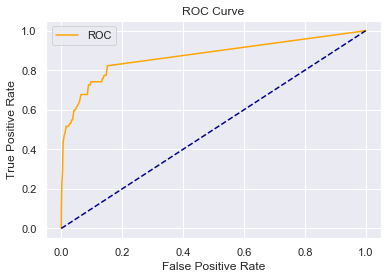

In [44]:
modelEval(ytest, yPreds)

From the above classification report, we can infer that our model trained on imbalanced data performs well on negative class but not the same for positive class.

### Part 2 - Modelling using Random Oversampling
For this part we would be handling the class imbalance. In order to see how our model performs on the randomly oversampled data. We will be using `Resample()` method to oversample the minority class i.e "1, signifying Defaulted"

In [9]:
def Resample(data, replace, n_samples, random_state = 123):
    np.random.seed(random_state)
    indices = data.index
    random_sampled_indices = np.random.choice(indices,
                                              size=n_samples,
                                              replace=replace)
    return data.loc[random_sampled_indices]

### Oversample the data

In [48]:
# Oversample the minority class.
negClass = loanData[loanData["Defaulted?"] == 0]
posClass = loanData[loanData["Defaulted?"] == 1]
posOverSampled = Resample(posClass, replace=True, n_samples=len(negClass))
overSampled = pd.concat([negClass, posOverSampled])

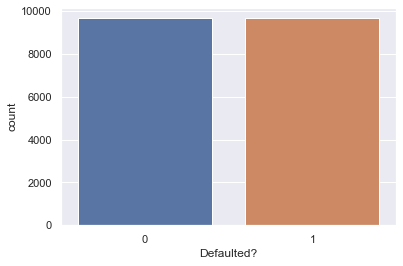

In [49]:
# Visualize the distibution of target classes.
sns.countplot(x="Defaulted?", data=overSampled)
plt.show()

From the above plot we can see that after resampling the minority class (Yes) is oversampled to be equal to the majority class (No). This solves our imbalanced data issue for this part.

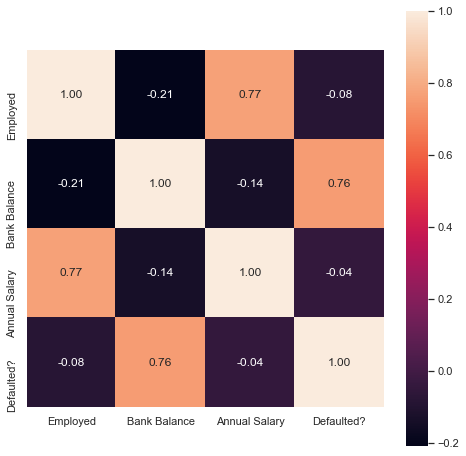

In [50]:
# Plot the correlation matrix as heatmap.
PlotHeatMap(overSampled)

In [51]:
features, target = FeatureTargetSplit(overSampled)

### Train Test Split
The dataset has to be split into training and test set. Here the dataset has 19334 observations and the test ratio is taken as 20% of the total observations. This indicates that the test set should have 20% * 19334 = 3866 observations and training set should have 15468 observations respectively.

In [59]:
Xtrain, Xtest, ytrain, ytest = TrainTestSplit(features, target, standardize=True)

### Training Decision Tree model
We will use `decision_tree()` API from mlpack to train the model on oversampled data.

In [53]:
# Create and train Decision Tree model.
output = mlpack.decision_tree(training=Xtrain, labels=ytrain, print_training_accuracy=True)

In [54]:
rf = output["output_model"]

### Making Predictions on Test set

In [55]:
# Predict the values for test data using previously trained model as input.
predictions = mlpack.decision_tree(input_model=rf, test=Xtest)

In [56]:
yPreds = predictions["predictions"].reshape(-1, 1).squeeze()

### Model Evaluation

Accuracy: 0.8763579927573719
ROC AUC: 0.8768037031326292
Cohen's Kappa: 0.7528943465235481
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1904
           1       0.90      0.85      0.87      1962

    accuracy                           0.88      3866
   macro avg       0.88      0.88      0.88      3866
weighted avg       0.88      0.88      0.88      3866



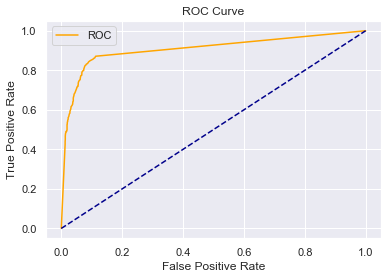

In [57]:
modelEval(ytest, yPreds)

From the above classification report, we can infer that our model trained on oversampled data performs well on both the classes, This proves the fact that imbalanced data has affected the model trained in part one. Also from the ROC AUC Curve, we can infer the True Positive Rate is around 85%, which is a good significance that our model performs well on unseen data.

### Part 3 - Modelling using Synthetic Minority Oversampling Technique
For this part we would be handling the class imbalance. In order to see how our model performs on the oversampled data using SMOTE. We will be using `SMOTE` API from imblearn to oversample the minority class i.e "1, signifying Defaulted"

In [62]:
smoteData = loanData.copy()

In [63]:
featureNames = ["Employed", "Bank Balance", "Annual Salary", "Defaulted?"]
features = loanData[featureNames]

In [64]:
from imblearn.over_sampling import SMOTE

In [65]:
os = SMOTE()
features, targets = os.fit_resample(features.iloc[:, :-1], features.iloc[:,-1])

### Train Test Split
The dataset has to be split into training and test set. The test ratio is taken as 20% of the total observations.

In [66]:
Xtrain, Xtest, ytrain, ytest = TrainTestSplit(features, targets, standardize=True)

### Training Decision Tree model
We will use `decision_tree()` API from mlpack to train the model on SMOTE data.

In [67]:
# Create and train Decision Tree model.
output = mlpack.decision_tree(training=Xtrain, labels=ytrain, print_training_accuracy=True)

In [68]:
rf = output["output_model"]

In [69]:
# Predict the values for test data using previously trained model as input.
predictions = mlpack.decision_tree(input_model=rf, test=Xtest)

In [70]:
yPreds = predictions["predictions"].reshape(-1, 1).squeeze()

### Model Evaluation

Accuracy: 0.8913605794102432
ROC AUC: 0.8914924756325264
Cohen's Kappa: 0.7827620309580027
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1952
           1       0.88      0.90      0.89      1914

    accuracy                           0.89      3866
   macro avg       0.89      0.89      0.89      3866
weighted avg       0.89      0.89      0.89      3866



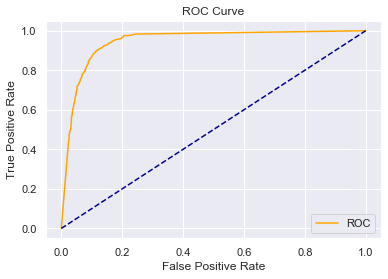

In [71]:
modelEval(ytest, yPreds)

From the above classification report, we can infer that our model trained on SMOTE data performs well on both the classes, There is some difference when compared to randomly oversampled data due to variation in the samples generated by SMOTE. Also from the ROC AUC Curve, we can infer the True Positive Rate is around 80%, which is a quantifies that our model performs well on unseen data.

### Part 4 - Modelling using Random Undersampling
For this part we would be handling the class imbalance by undersampling the majority class, to see how well our model trains and performs on randomly undersampled data.

Since the size of the data set is quite small, undersampling of majority class would not make much sense here. But still we are going forward with this part to get a sense of how our model performs on less amount of data and it's impact on the learning.

In [10]:
# Undersample the majority class.
negClass = loanData[loanData["Defaulted?"] == 0]
posClass = loanData[loanData["Defaulted?"] == 1]
negUnderSampled = Resample(negClass, replace=True, n_samples=len(posClass))
underSampled = pd.concat([negUnderSampled, posClass])

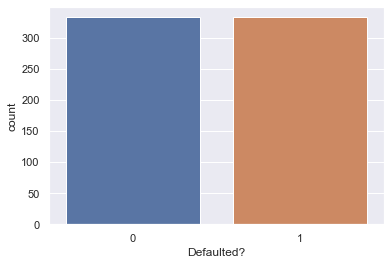

In [11]:
# Visualize the distibution of target classes.
sns.countplot(x="Defaulted?", data=underSampled)
plt.show()

From the above plot we can see that after resampling the majority class (No) is undersampled to be equal to the majority class (Yes). This solves our imbalanced data issue for this part.

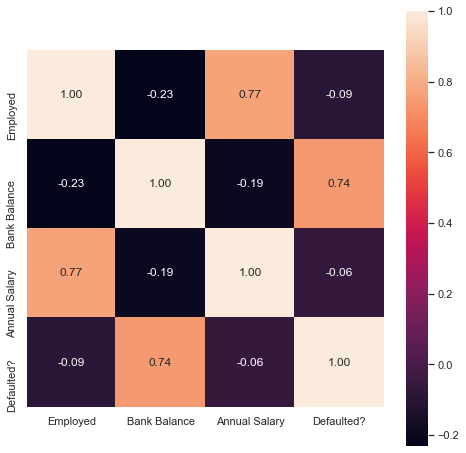

In [14]:
# Plot the correlation matrix as heatmap.
PlotHeatMap(underSampled)

In [18]:
features, target = FeatureTargetSplit(underSampled)

### Train Test Split
The dataset has to be split into training and test set. Here the dataset has 666 observations and the test ratio is taken as 20% of the total observations. This indicates that the test set should have 20% * 666 = 133 observations and training set should have 533 observations respectively.

In [77]:
Xtrain, Xtest, ytrain, ytest = TrainTestSplit(features, target, standardize=True)

### Training Decision Tree model
We will use `decision_tree()` API from mlpack to train the model on random undersampled data.

In [78]:
# Create and train Random Forest model with 100 trees.
output = mlpack.decision_tree(training=Xtrain, labels=ytrain, print_training_accuracy=True)

In [79]:
rf = output["output_model"]

### Making Predictions on Test set

In [80]:
# Predict the values for test data using previously trained model as input.
predictions = mlpack.decision_tree(input_model=rf, test=Xtest)

In [81]:
yPreds = predictions["predictions"].reshape(-1, 1).squeeze()

### Model Evaluation

Accuracy: 0.8872180451127819
ROC AUC: 0.8902771467514766
Cohen's Kappa: 0.7750084583286343
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        71
           1       0.84      0.94      0.89        62

    accuracy                           0.89       133
   macro avg       0.89      0.89      0.89       133
weighted avg       0.89      0.89      0.89       133



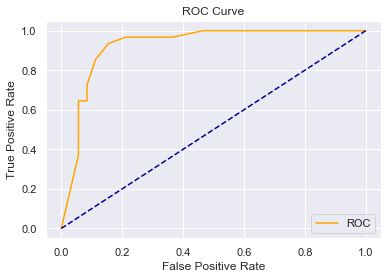

In [82]:
modelEval(ytest, yPreds)

From the above classification report, we can infer that our model trained on undersampled data performs well on both the classes compared to imbalanced model in Part 1. Also from the ROC AUC Curve, we can infer the True Positive Rate is around 80% although there is a small flatline, but still performs better than imbalanced model.

### Conclusion
Models trained on resampled data performs well, but there is still room for improvement. Feel free to play around with the hyperparameters, training data split ratio etc. 